In [2]:
import os
import keras
from scipy.io import wavfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Conv2D, MaxPool2D, Flatten, LSTM, GRU
from keras.layers import Dropout, Dense, TimeDistributed, Bidirectional
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from python_speech_features import mfcc
import pickle
from keras.callbacks import ModelCheckpoint
from cfg import Config
from keras import optimizers
from keras import regularizers
from time import perf_counter
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.multiclass import type_of_target

In [3]:
def check_data():
    if os.path.isfile(config.p_path):
        print('Loading existing data for {} model'.format(config.mode))
        with open(config.p_path, 'rb') as handle:
            tmp = pickle.load(handle)
            return tmp
    else:
        return None

In [4]:
def build_rand_feat():
    tmp = check_data()
    if tmp:
        return tmp.data[0], tmp.data[1]
    X = []
    y = []
    _min, _max = float('inf'), -float('inf')
    for _ in tqdm(range(n_samples)):
        rand_class = np.random.choice(class_dist.index, p=prob_dist)
        file = np.random.choice(df[df.label==rand_class].index)
        rate, wav = wavfile.read('train_outer_files/'+file) #what if we use wavfiles/clean
        label = df.at[file, 'label']
        rand_index = np.random.randint(0, wav.shape[0]-config.step)  #random index for sampling start point      
        sample = wav[rand_index:rand_index+config.step] #sampling end after 0.1 second or 4410 index 
        X_sample = mfcc(sample, rate,numcep=config.nfeat, nfilt=config.nfilt,
                        nfft=config.nfft) #Noted that in here the ata is tranformed into MFCC type
        _min = min(np.amin(X_sample), _min)
        _max = max(np.amax(X_sample), _max)
        X.append(X_sample)
        y.append(classes.index(label))
        #print("1. ", type_of_target(y))
    config.min = _min
    config.max = _max
    X, y = np.array(X), np.array(y)
    #print("2. ", type_of_target(y))
    X = (X - _min) / (_max - _min)
    if config.mode == 'mlp_outer_kfold':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2])
    
    #print("3. ", type_of_target(y))
    #y = to_categorical(y, num_classes = 7)
    #print("4. ", type_of_target(y))
    config.data = (X, y)
    #print("5. ", type_of_target(y))
    
    with open(config.p_path, 'wb') as handle:
        pickle.dump(config, handle, protocol=2)
    
    return X, y

In [16]:
def get_mlp_model():
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(7, activation='softmax'))
    model.compile(loss='categorical_crossentropy', 
                  optimizer=keras.optimizers.Adam(lr=0.001), 
                  metrics=['acc'] )
    return model

In [17]:
df = pd.read_csv('train_outer_sound.csv')
df.set_index('fname', inplace=True)

for f in df.index:
    rate, signal = wavfile.read('train_outer_files/'+f) #interchangeable wavfiles/clean
    df.at[f, 'length'] = signal.shape[0]/rate

classes = list(np.unique(df.label))
class_dist = df.groupby(['label'])['length'].mean()

n_samples = 2 * int(df['length'].sum()/0.5) 
#we sample through 0.1 s of each audio, 
#We use the factor 2 to avoid moving exactly after 0.1s to the next 0.1s directly 
#Instead, take a 0.05s step forward and then sample the next 0.1s from that point
#It means that the second half of the last sample becomes the first half 
#of the next sample. E.g; first sample time range: 0.1s to 0.2s, 
#second sample time range: 0.15s to 0.25s
 
prob_dist = class_dist / class_dist.sum()
choices = np.random.choice(class_dist.index, p=prob_dist)

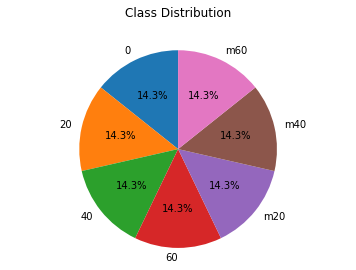

In [18]:
fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%',
       shadow=False, startangle=90)
ax.axis('equal')
plt.show()

In [19]:
config = Config(mode='mlp_outer_kfold')

if config.mode == 'mlp_outer_kfold':
    X, y = build_rand_feat()
    #y_flat = np.argmax(y, axis=1) #return the index value
    input_shape = (X.shape[1], X.shape[2])
    t1_start = perf_counter()
    model = get_mlp_model()

#class_weight = compute_class_weight('balanced', 
#                                    np.unique(y_flat),
#                                   y_flat)

checkpoint = ModelCheckpoint(config.model_path, monitor='val_acc', verbose=1, mode='max',
                             save_best_only=True, save_weights_only=False, period=1)

# fix random seed for reproducibility
#seed = 7
#np.random.seed(seed)

# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True)
cvscores = []

i = 1

for train, test in kfold.split(X, y):
    y_binary = to_categorical(y, num_classes = 7)
    print("Fold: ", i)
    print("")
    model.fit(X, y_binary, epochs=5, batch_size=400,
              callbacks = [checkpoint])
    scores = model.evaluate(X[test], y_binary[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    print("")
    i+=1
    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

model.save(config.model_path)

Loading existing data for mlp_outer_kfold model
Fold:  1

Epoch 1/5
5582/5582 [==============================] - ETA: 1:00 - loss: 1.9550 - acc: 0.172 - ETA: 17s - loss: 1.9537 - acc: 0.165 - ETA: 11s - loss: 1.9499 - acc: 0.16 - ETA: 8s - loss: 1.9507 - acc: 0.1670 - ETA: 6s - loss: 1.9514 - acc: 0.162 - ETA: 4s - loss: 1.9509 - acc: 0.160 - ETA: 3s - loss: 1.9500 - acc: 0.160 - ETA: 2s - loss: 1.9500 - acc: 0.159 - ETA: 2s - loss: 1.9498 - acc: 0.158 - ETA: 0s - loss: 1.9501 - acc: 0.154 - ETA: 0s - loss: 1.9504 - acc: 0.151 - 5s 982us/step - loss: 1.9501 - acc: 0.1525


C:\Users\hp\Anaconda3\lib\site-packages\keras\callbacks.py:434: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


Epoch 2/5
5582/5582 [==============================] - ETA: 0s - loss: 1.9479 - acc: 0.130 - ETA: 0s - loss: 1.9477 - acc: 0.125 - ETA: 0s - loss: 1.9473 - acc: 0.152 - ETA: 0s - loss: 1.9469 - acc: 0.156 - ETA: 0s - loss: 1.9473 - acc: 0.155 - ETA: 0s - loss: 1.9477 - acc: 0.155 - ETA: 0s - loss: 1.9472 - acc: 0.151 - ETA: 0s - loss: 1.9469 - acc: 0.152 - ETA: 0s - loss: 1.9471 - acc: 0.150 - 1s 120us/step - loss: 1.9473 - acc: 0.1496
Epoch 3/5
5582/5582 [==============================] - ETA: 0s - loss: 1.9491 - acc: 0.155 - ETA: 0s - loss: 1.9449 - acc: 0.159 - ETA: 0s - loss: 1.9466 - acc: 0.154 - ETA: 0s - loss: 1.9469 - acc: 0.150 - ETA: 0s - loss: 1.9467 - acc: 0.153 - ETA: 0s - loss: 1.9466 - acc: 0.150 - ETA: 0s - loss: 1.9472 - acc: 0.150 - ETA: 0s - loss: 1.9476 - acc: 0.150 - ETA: 0s - loss: 1.9476 - acc: 0.153 - 1s 118us/step - loss: 1.9475 - acc: 0.1546
Epoch 4/5
5582/5582 [==============================] - ETA: 1s - loss: 1.9459 - acc: 0.155 - ETA: 0s - loss: 1.9489 - ac

5582/5582 [==============================] - ETA: 0s - loss: 1.8669 - acc: 0.252 - ETA: 0s - loss: 1.8760 - acc: 0.216 - ETA: 0s - loss: 1.8645 - acc: 0.225 - 0s 31us/step - loss: 1.8592 - acc: 0.2318
Epoch 5/5
5582/5582 [==============================] - ETA: 0s - loss: 1.8263 - acc: 0.260 - ETA: 0s - loss: 1.8657 - acc: 0.224 - ETA: 0s - loss: 1.8567 - acc: 0.231 - 0s 25us/step - loss: 1.8540 - acc: 0.2325
acc: 25.99%

Fold:  7

Epoch 1/5
5582/5582 [==============================] - ETA: 0s - loss: 1.8459 - acc: 0.207 - ETA: 0s - loss: 1.8327 - acc: 0.242 - ETA: 0s - loss: 1.8392 - acc: 0.239 - 0s 31us/step - loss: 1.8368 - acc: 0.2390
Epoch 2/5
5582/5582 [==============================] - ETA: 0s - loss: 1.8168 - acc: 0.245 - ETA: 0s - loss: 1.8216 - acc: 0.248 - ETA: 0s - loss: 1.8285 - acc: 0.244 - 0s 28us/step - loss: 1.8285 - acc: 0.2445
Epoch 3/5
5582/5582 [==============================] - ETA: 0s - loss: 1.8414 - acc: 0.245 - ETA: 0s - loss: 1.8290 - acc: 0.261 - ETA: 0s - lo

In [ ]:
y

In [ ]:
y.shape